In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd

In [2]:
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [8]:
N = 6e5

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
# train_split_data = len(data)//3
train_test_split_data = int(len(data)*0.5)
train_data = data[:train_test_split_data]
test_data = data[train_test_split_data:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_split_mc = int(len(data)*0.8)
train_mc = mc[:train_test_split_mc]
test_mc = mc[train_test_split_mc:]

In [125]:
def reweight_train(data,mc,feats,cla,eval_data=None,eval_mc=None,plot=True,reweighing=True,q_weights=0.9999):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from hep_ml.reweight import GBReweighter
    from sklearn.metrics import roc_curve, roc_auc_score

    scaler_mc = MinMaxScaler()
    scaler_data = MinMaxScaler()

    def remove_outliers(data,q1=0.05,q2=0.95):
        mask = np.ones(len(data),dtype=bool)
        for col in data.columns:
            mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
        return mask
    
    #Try and remove outliers at first step
    data = data[remove_outliers(data[feats])]
    mc = mc[remove_outliers(mc[feats])]
    
    data_split = len(data)//2
    mc_split = len(mc)//2
    
    train_data = data[:data_split]
    train_data_cla = data[data_split:]
    
    train_mc = mc[:mc_split]
    train_mc_cla = mc[mc_split:]
    
#     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats][remove_outliers(train_data[feats])]),columns=feats)
#     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats][remove_outliers(train_mc[feats])]),columns=feats)
    scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats]),columns=feats)
    scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats]),columns=feats)

    scaled_train_data_cla = pd.DataFrame(scaler_data.transform(train_data_cla[feats]),columns=feats)
    scaled_train_mc_cla = pd.DataFrame(scaler_mc.transform(train_mc_cla[feats]),columns=feats)
    
#     #Try and remove outliers
#     scaled_train_data_cla[remove_outliers(scaled_train_data_cla)]
#     scaled_train_mc_cla[remove_outliers(scaled_train_mc_cla)]
    
    if plot:
        for feat in feats:
            scaled_train_data[feat].hist(bins=100,alpha=0.5);
            scaled_train_mc[feat].hist(bins=100,alpha=0.5);
            plt.yscale('log')
            plt.title(feat)
            plt.show()
    
    if reweighing:
        reweighter = GBReweighter(n_estimators=80,max_depth=2,min_samples_leaf=200,loss_regularization=10.0)
        reweighter.fit(original=scaled_train_mc, target=scaled_train_data)
        
        mc_weights = reweighter.predict_weights(scaled_train_mc_cla)
        
        mask = mc_weights < np.quantile(mc_weights, (q_weights))
        
        plt.hist(mc_weights[mask],bins=100)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        
        if plot:
            for feat in feats:
                scaled_train_data_cla[feat].hist(bins=100,alpha=0.5);
                scaled_train_mc_cla[mask][feat].hist(bins=100,alpha=0.5,weights=mc_weights[mask]);
                plt.yscale('log')
                plt.title(feat)
                plt.show()
        
        cla.fit(X=scaled_train_mc_cla[mask],
               y=train_mc_cla.trueKs[mask],
               sample_weight = mc_weights[mask])
        
        if type(eval_data) != type(None) and type(eval_mc) != type(None):
            scaled_eval_data = pd.DataFrame(scaler_data.transform(eval_data[feats]),columns=feats)
            scaled_eval_mc = pd.DataFrame(scaler_mc.transform(eval_mc[feats]),columns=feats)
            
            #Check how distinguishable after reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))),
                        sample_weight = np.append(mc_weights[mask],np.ones(len(scaled_train_data_cla))))
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fig, ax = plt.subplots()
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'b.')
            
            #check before reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))))
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'rx')
    else:
        cla.fit(X=scaled_train_mc_cla,
                y=train_mc_cla.trueKs)
    return scaler_data, scaler_mc

In [7]:
cla_reweight1 = xgb.XGBClassifier()
cla_reweight2 = xgb.XGBClassifier()
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

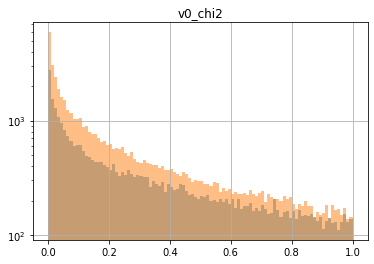

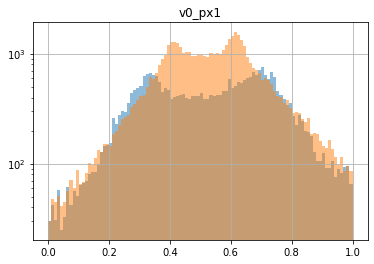

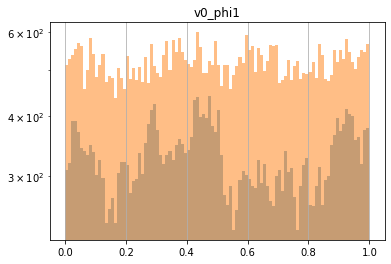

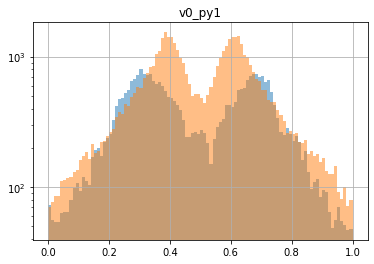

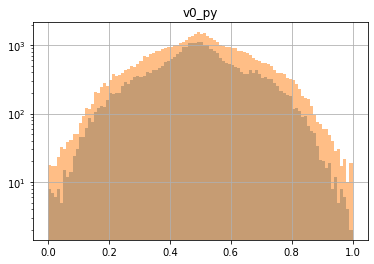

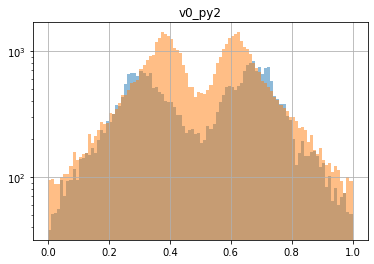

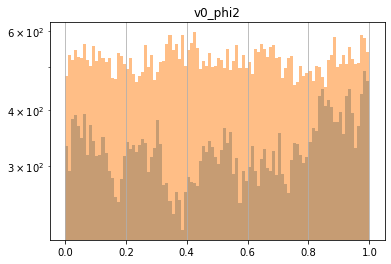

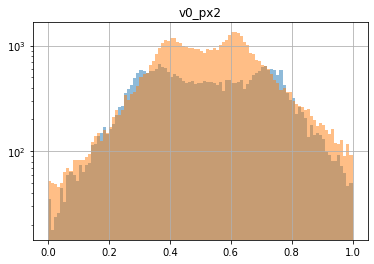

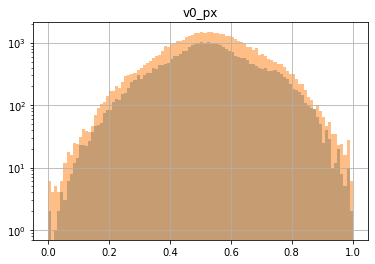

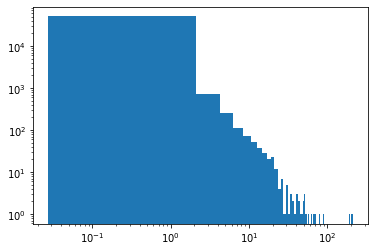

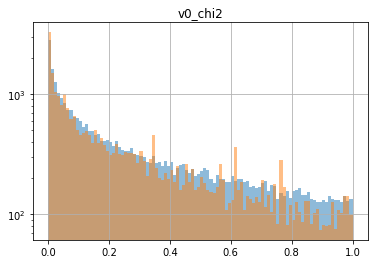

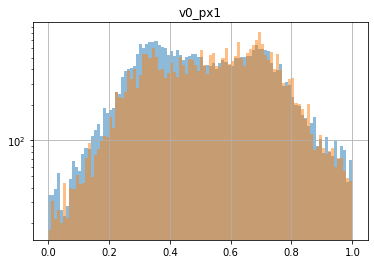

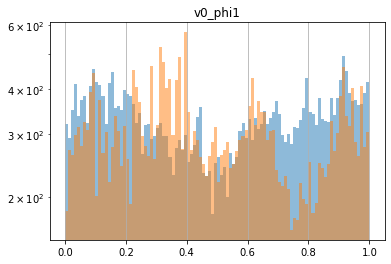

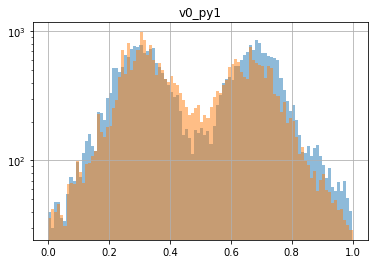

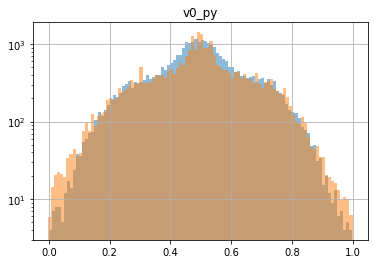

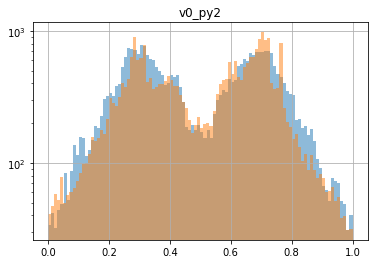

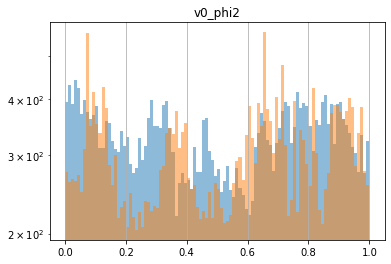

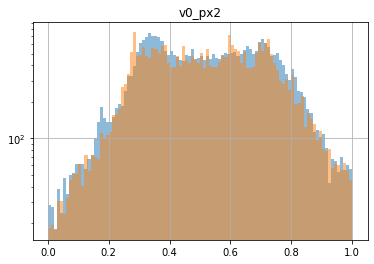

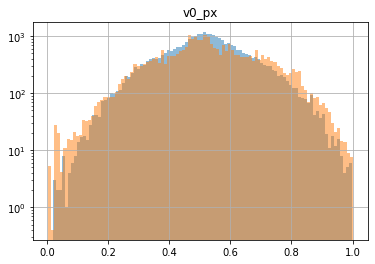

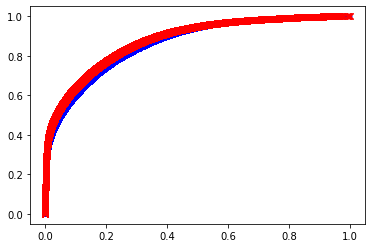

In [126]:
scaler_data_reweight1, scaler_mc_reweight1 = reweight_train(train_data,train_mc,ML1,cla_reweight1,test_data,test_mc,q_weights=1)

In [32]:
scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False)

No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 6169 +/- 222, background: 116919
Completed fit with Chi2: 78.5, p-val: 0.822 and the total amount of signal 2731 +/- 175, background: 108050
No valid minimum found!
Completed fit with Chi2: 83.3, p-val: 0.706 and the total amount of signal 1504 +/- 3836, background: 96967
Completed fit with Chi2: 85.6, p-val: 0.639 and the total amount of signal 949 +/- 134, background: 85214
Completed fit with Chi2: 79.9, p-val: 0.791 and the total amount of signal 659 +/- 96, background: 73194
Completed fit with Chi2: 78.9, p-val: 0.813 and the total amount of signal 450 +/- 102, background: 61094
Completed fit with Chi2: 88.5, p-val: 0.555 and the total amount of signal 313 +/- 92, background: 48923
Completed fit with Chi2: 97.4, p-val: 0.305 and the total amount of signal 210 +/- 90, background: 36717
Completed fit with Chi2: 92.1, p-val: 0.448 and the total amount of signal 132 +/- 4, background: 244

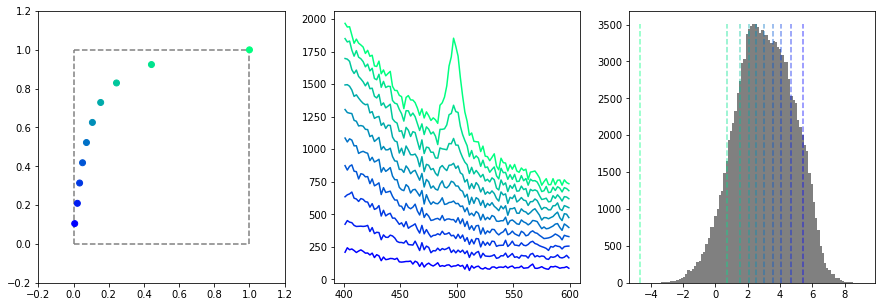

In [116]:
import importlib 
hm = importlib.reload(hm)

p1_reweight = cla_reweight1.predict_proba(pd.DataFrame(scaler_mc_reweight1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1r, ax1r = plt.subplots(figsize = (15,5),ncols=3)

AUC1r, cuts1r = hm.roc_curve_data(test_data.v0_ks_mass, p1_reweight,Npoints=10,ax_roc=ax1r[0],ax_fits=ax1r[1],ax_hist=ax1r[2])

No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 6169 +/- 222, background: 116919
Completed fit with Chi2: 85.4, p-val: 0.645 and the total amount of signal 1835 +/- 200, background: 108946
Completed fit with Chi2: 80.8, p-val: 0.768 and the total amount of signal 1000 +/- 114, background: 97471
Completed fit with Chi2: 82.4, p-val: 0.730 and the total amount of signal 798 +/- 22, background: 85364
Completed fit with Chi2: 93.0, p-val: 0.422 and the total amount of signal 557 +/- 78, background: 73297
Completed fit with Chi2: 95.6, p-val: 0.350 and the total amount of signal 414 +/- 19, background: 61131
Completed fit with Chi2: 90.4, p-val: 0.498 and the total amount of signal 308 +/- 5, background: 48928
Completed fit with Chi2: 92.5, p-val: 0.437 and the total amount of signal 263 +/- 51, background: 36664
Completed fit with Chi2: 97.0, p-val: 0.313 and the total amount of signal 160 +/- 111, background: 24459
Completed fit with Chi2

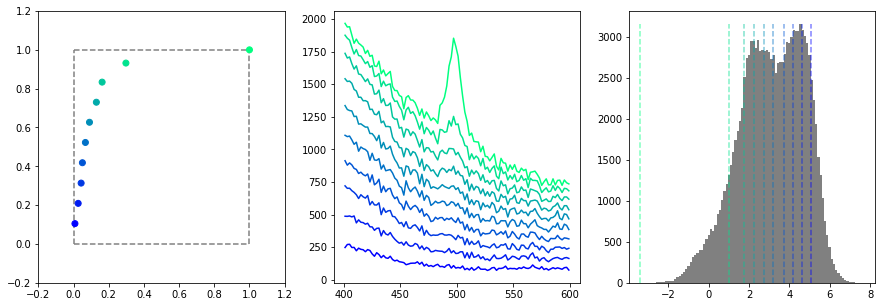

In [37]:
p1 = cla1.predict_proba(pd.DataFrame(scaler_mc_1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_ks_mass, p1,Npoints=10,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2])

In [56]:
1+AUC1, 1+AUC1r

(0.8819262139673288, 0.863214349722689)

In [71]:
if type(train_data) != type(None):
    print('ok')

ok


In [67]:
type(None)

NoneType